Grant Waldow

In [1]:
!pip3 install torch torchvision

In [2]:
import tensorflow as tf

In [3]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/data/HW6

/content/drive/MyDrive/data/HW6


In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

In [7]:
print(torch.device("cuda:0"))

cuda:0


# Define learning parameters

In [8]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [9]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 93333762.66it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 20653997.24it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68930753.17it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4715477.42it/s]


Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [47]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [48]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [49]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [50]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [51]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [52]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [53]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [54]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [55]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [56]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [57]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    criterion = nn.BCELoss()
    loss = criterion(output, true_label)
    return loss

def discriminator_loss(output, true_label):
    criterion = nn.BCELoss()
    loss = criterion(output, true_label)
    return loss

# Q. Write training loop (for 1.a)

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        real_images, _ = data
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Adjust label size based on current batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # Train Discriminator
        discriminator.zero_grad()

        # Train Discriminator with Real Images
        outputs = discriminator(real_images)
        print(f"Discriminator output size (real): {outputs.size()}, Label size (real): {real_labels.size()}")
        real_loss = discriminator_loss(outputs, real_labels)

        # Generate Fake Images
        noise = create_noise(current_batch_size, nz)  # Adjust noise vector size
        fake_images = generator(noise)

        # Train Discriminator with Fake Images
        outputs = discriminator(fake_images.detach())
        print(f"Discriminator output size (fake): {outputs.size()}, Label size (fake): {fake_labels.size()}")
        fake_loss = discriminator_loss(outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_d.step()

        loss_d += d_loss.item()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = generator_loss(outputs, real_labels)
        g_loss.backward()
        optim_g.step()

        loss_g += g_loss.item()




    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    generated_img = make_grid(generated_img)

    # vis
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the model
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [22]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [25]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

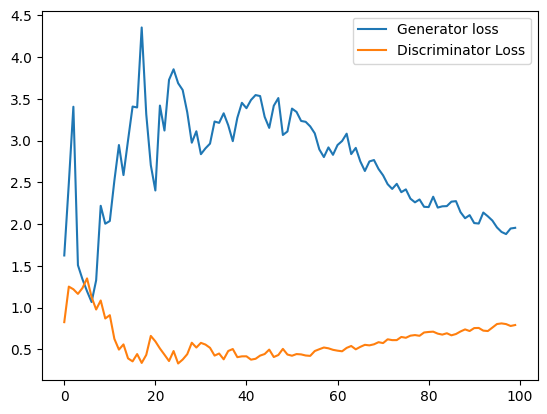

In [24]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

# Part 1.B

In [42]:
def generator_loss_alternative(discriminator_output):
    # Using the alternative loss function for the generator for part (b) of Q1
    return torch.mean(torch.log(1. - discriminator_output))

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        real_images, _ = data
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Adjust label size based on current batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # Train Discriminator
        discriminator.zero_grad()

        # Train Discriminator with Real Images
        outputs = discriminator(real_images)
        print(f"Discriminator output size (real): {outputs.size()}, Label size (real): {real_labels.size()}")
        real_loss = discriminator_loss(outputs, real_labels)

        # Generate Fake Images
        noise = create_noise(current_batch_size, nz)  # Adjust noise vector size
        fake_images = generator(noise)

        # Train Discriminator with Fake Images
        outputs = discriminator(fake_images.detach())
        print(f"Discriminator output size (fake): {outputs.size()}, Label size (fake): {fake_labels.size()}")
        fake_loss = discriminator_loss(outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_d.step()

        loss_d += d_loss.item()

        # Train Generator (but with the worse loss function this time)
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = generator_loss_alternative(outputs)
        g_loss.backward()
        optim_g.step()

        loss_g += g_loss.item()


    # create the final fake image for epoch
    generated_img = generator(noise).cpu().detach()
    generated_img = make_grid(generated_img)
    # vis
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated models
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [44]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [45]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

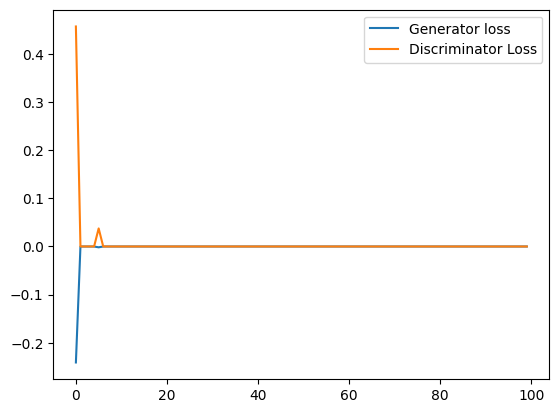

In [46]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

# Q 1.c

In [58]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # using convolutional layers
            nn.ConvTranspose2d(self.nz, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape latent vector of size [784,] to [28,28] if it isn't shaped like that yet
        return self.main(x).view(-1, 1).squeeze(1)


  2%|▏         | 2/117 [00:00<00:12,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:11,  9.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:11,  9.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:11,  9.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  9.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  9.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:10,  9.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:01<00:11,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  9.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:09,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:09,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  9.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  9.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:08,  9.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:03<00:08,  9.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:04<00:07,  9.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:07,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  9.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:06<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:07<00:05,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:08<00:04,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:09<00:03,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:02,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:10<00:02,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:11<00:01,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:11<00:01,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:12<00:00,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  9.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.92it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 1 of 100
Generator loss: 1.42600498, Discriminator loss: 0.88886768


  1%|          | 1/117 [00:00<00:12,  9.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:12,  9.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:10,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:10,  9.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:10,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  9.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  9.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:09,  9.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:09,  9.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:02<00:09,  9.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:09,  9.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  9.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:03<00:09,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:03<00:09,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:08,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  9.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  9.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  9.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  9.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:04<00:07,  9.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:04<00:07,  9.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:07,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:05<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:06<00:06,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:06<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:07<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:07<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:08<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:08<00:04,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:09<00:03,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:09<00:03,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:10<00:02,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:10<00:02,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:11<00:01,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:11<00:01,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:12<00:00,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:12<00:00,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.86it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 2 of 100
Generator loss: 2.87574935, Discriminator loss: 1.41486988


  1%|          | 1/117 [00:00<00:12,  9.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:12,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  9.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  9.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  9.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:00<00:12,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:11,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:11,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:07<00:05,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:08<00:04,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:10<00:02,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:11<00:01,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.68it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 3 of 100
Generator loss: 5.47484012, Discriminator loss: 0.24213281


  1%|          | 1/117 [00:00<00:12,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:15,  7.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  9.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:08,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  9.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  9.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  9.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  9.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:06<00:06,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:05,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:07<00:05,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:07<00:05,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:08<00:04,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:09<00:03,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:10<00:02,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:10<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:11<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.72it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 4 of 100
Generator loss: 3.37130008, Discriminator loss: 1.05913951


  1%|          | 1/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:10,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:10,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:09,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  9.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  9.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  9.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  9.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:03<00:08,  9.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:08,  9.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:08,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  9.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  9.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  9.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  9.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  9.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:04<00:08,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:07,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:07,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:05<00:07,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:06<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:07<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:07<00:05,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  9.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  9.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  9.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:08<00:04,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:08<00:04,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:03,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:09<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:09<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:10<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:10<00:02,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:11<00:01,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:11<00:01,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  9.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:00,  9.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:12<00:00,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:12<00:00,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.86it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


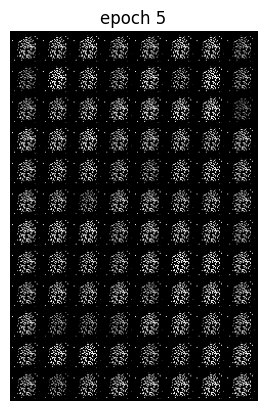

Epoch 5 of 100
Generator loss: 2.15921759, Discriminator loss: 0.95979856


  1%|          | 1/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:14,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:14,  7.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:11,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  9.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:01,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.64it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 6 of 100
Generator loss: 2.24142961, Discriminator loss: 0.97014986


  1%|          | 1/117 [00:00<00:12,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:11,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:11,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:09,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:01,  5.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  7.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.47it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 7 of 100
Generator loss: 2.48935330, Discriminator loss: 1.12169699


  2%|▏         | 2/117 [00:00<00:13,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.68it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 8 of 100
Generator loss: 1.70340212, Discriminator loss: 1.18597974


  1%|          | 1/117 [00:00<00:12,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:12,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:11,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:11,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:03<00:09,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:05,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.63it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 9 of 100
Generator loss: 2.20930492, Discriminator loss: 0.93039273


  1%|          | 1/117 [00:00<00:13,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:10,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:10,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:03<00:09,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:06,  7.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  7.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:05,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:05,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.56it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


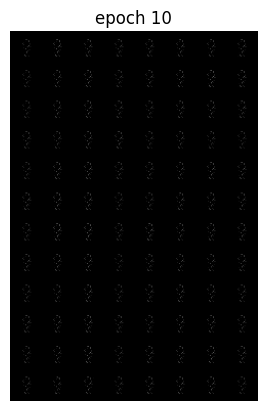

Epoch 10 of 100
Generator loss: 1.32796914, Discriminator loss: 1.10430705


  1%|          | 1/117 [00:00<00:13,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:08,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:06,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:07<00:05,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:04,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.60it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 11 of 100
Generator loss: 1.87565139, Discriminator loss: 0.64127469


  1%|          | 1/117 [00:00<00:15,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:09,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:10,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:09,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:06,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:03,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  7.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.50it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 12 of 100
Generator loss: 2.43270252, Discriminator loss: 0.62193376


  1%|          | 1/117 [00:00<00:13,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:08,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:06,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:07<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.65it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 13 of 100
Generator loss: 2.95263730, Discriminator loss: 0.45484011


  1%|          | 1/117 [00:00<00:13,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:08,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:08,  7.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.57it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 14 of 100
Generator loss: 3.02196243, Discriminator loss: 0.54392828


  1%|          | 1/117 [00:00<00:15,  7.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:15,  7.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:15,  7.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:01<00:13,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:08,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:06,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:03,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.46it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


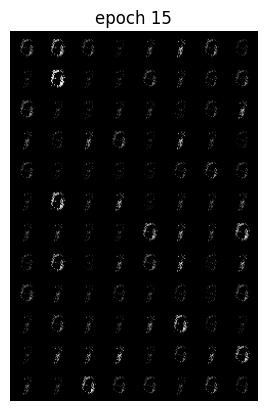

Epoch 15 of 100
Generator loss: 2.86294595, Discriminator loss: 0.43181471


  1%|          | 1/117 [00:00<00:13,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:02,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.55it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 16 of 100
Generator loss: 3.21789699, Discriminator loss: 0.34072078


  1%|          | 1/117 [00:00<00:13,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:12,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:11,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.55it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 17 of 100
Generator loss: 3.65477669, Discriminator loss: 0.37609862


  1%|          | 1/117 [00:00<00:13,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:12,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:09,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.57it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 18 of 100
Generator loss: 3.44105395, Discriminator loss: 0.40174210


  1%|          | 1/117 [00:00<00:13,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:10,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:08,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:08,  7.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.49it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 19 of 100
Generator loss: 3.77517029, Discriminator loss: 0.32494949


  1%|          | 1/117 [00:00<00:13,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:11,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:10,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:10,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:14,  5.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:11,  7.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:10,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:03,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  9.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  9.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  9.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.47it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


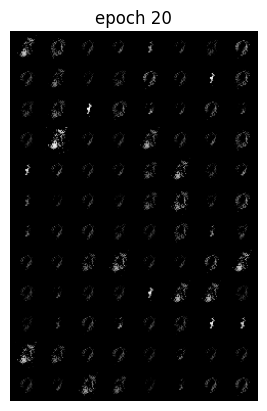

Epoch 20 of 100
Generator loss: 3.46422703, Discriminator loss: 0.46308003


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:08,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.52it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 21 of 100
Generator loss: 2.78619722, Discriminator loss: 0.56661362


  1%|          | 1/117 [00:00<00:13,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  7.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:10,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:09,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:09,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:09,  7.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:07<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:10<00:04,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:11<00:03,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:03,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.30it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 22 of 100
Generator loss: 2.89503306, Discriminator loss: 0.52090947


  1%|          | 1/117 [00:00<00:13,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:11,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:09,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:06,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:03,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.49it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 23 of 100
Generator loss: 3.40284527, Discriminator loss: 0.36837682


  1%|          | 1/117 [00:00<00:13,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:11,  7.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:11,  7.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:05,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:01,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.38it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 24 of 100
Generator loss: 3.69072622, Discriminator loss: 0.40551890


  1%|          | 1/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:05,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:03,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:03,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.41it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


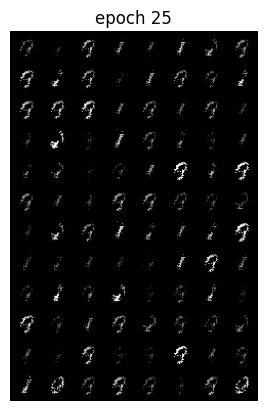

Epoch 25 of 100
Generator loss: 3.26919026, Discriminator loss: 0.50882020


  1%|          | 1/117 [00:00<00:14,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:02,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:02,  7.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.40it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 26 of 100
Generator loss: 3.45556537, Discriminator loss: 0.38507094


  0%|          | 0/117 [00:00<?, ?it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:15,  7.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:14,  7.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:15,  7.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:01<00:14,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:02<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:05,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.37it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 27 of 100
Generator loss: 3.25143863, Discriminator loss: 0.53643632


  2%|▏         | 2/117 [00:00<00:15,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:01<00:13,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:08,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:08,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.41it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 28 of 100
Generator loss: 3.72288306, Discriminator loss: 0.39214729


  1%|          | 1/117 [00:00<00:14,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.47it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 29 of 100
Generator loss: 3.29202641, Discriminator loss: 0.49015919


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:12,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:12,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:09,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.39it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


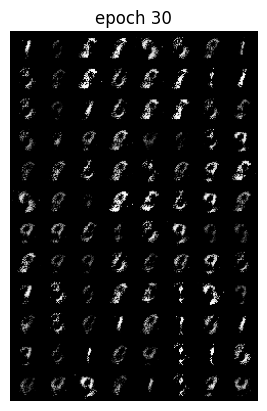

Epoch 30 of 100
Generator loss: 2.83466380, Discriminator loss: 0.52843504


  1%|          | 1/117 [00:00<00:15,  7.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:02,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  7.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:01,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.39it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 31 of 100
Generator loss: 3.56375163, Discriminator loss: 0.44034983


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:08,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:06,  5.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:05,  6.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:02,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  9.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:01,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.40it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 32 of 100
Generator loss: 3.53152621, Discriminator loss: 0.41246005


  2%|▏         | 2/117 [00:00<00:13,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:13,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  9.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  9.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.67it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 33 of 100
Generator loss: 2.95296549, Discriminator loss: 0.48925380


  1%|          | 1/117 [00:00<00:13,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:15,  7.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:14,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.49it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 34 of 100
Generator loss: 3.48858666, Discriminator loss: 0.53148820


  1%|          | 1/117 [00:00<00:13,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  7.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:05,  7.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:05,  7.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.30it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


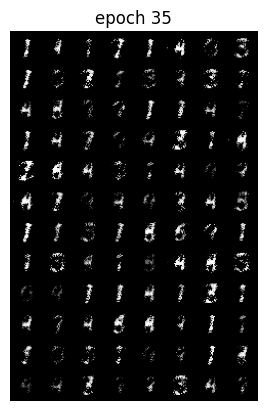

Epoch 35 of 100
Generator loss: 3.48944224, Discriminator loss: 0.39021258


  1%|          | 1/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:06,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.32it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 36 of 100
Generator loss: 3.42685886, Discriminator loss: 0.44121254


  1%|          | 1/117 [00:00<00:15,  7.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:13,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:11,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:04,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:04,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  7.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:03,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.37it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 37 of 100
Generator loss: 3.14868437, Discriminator loss: 0.50589829


  1%|          | 1/117 [00:00<00:14,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:10,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:06,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:04,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:03,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:03,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:02,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:01,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  7.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.33it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 38 of 100
Generator loss: 2.87729533, Discriminator loss: 0.51644082


  0%|          | 0/117 [00:00<?, ?it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:09,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:09,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:08,  7.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:08,  7.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:08,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:04,  7.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:03,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:02,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:01,  7.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  7.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.27it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 39 of 100
Generator loss: 3.17491924, Discriminator loss: 0.41308673


  1%|          | 1/117 [00:00<00:13,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:15,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:14,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:01<00:13,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:09,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:05,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:05,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.31it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


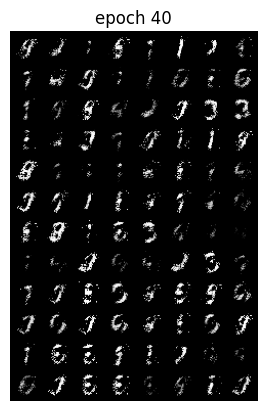

Epoch 40 of 100
Generator loss: 3.56391935, Discriminator loss: 0.40089999


  1%|          | 1/117 [00:00<00:14,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:13,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:09,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  7.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:02,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.31it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 41 of 100
Generator loss: 3.40228814, Discriminator loss: 0.45836888


  1%|          | 1/117 [00:00<00:15,  7.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:15,  7.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:15,  7.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:14,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:14,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:01<00:13,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:13,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:13,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:02<00:12,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:03<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:09,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:08,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:07<00:07,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:07,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:07,  7.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:08<00:06,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:08<00:06,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:09<00:05,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:09<00:05,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:10<00:04,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:10<00:04,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:10<00:04,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:11<00:03,  7.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:11<00:03,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:11<00:03,  7.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:12<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:12<00:02,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:12<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:13<00:01,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:13<00:01,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:14<00:00,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:14<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:14<00:00,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.11it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 42 of 100
Generator loss: 3.21324490, Discriminator loss: 0.44103828


  1%|          | 1/117 [00:00<00:13,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:01<00:14,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:13,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:12,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:03<00:11,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:06,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:10<00:04,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:01,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.30it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 43 of 100
Generator loss: 3.49161478, Discriminator loss: 0.37932961


  1%|          | 1/117 [00:00<00:13,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:12,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:12,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:11,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:11,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:10,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:08,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:07<00:07,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:08<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:09<00:05,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:10<00:04,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:10<00:04,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:11<00:03,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:11<00:03,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:12<00:02,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:13<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:14<00:00,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.04it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 44 of 100
Generator loss: 3.31897207, Discriminator loss: 0.47302240


  1%|          | 1/117 [00:00<00:14,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:10,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:08,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:08,  7.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:08,  7.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  7.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:07,  7.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:10<00:04,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:11<00:03,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:02,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:14<00:00,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.25it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


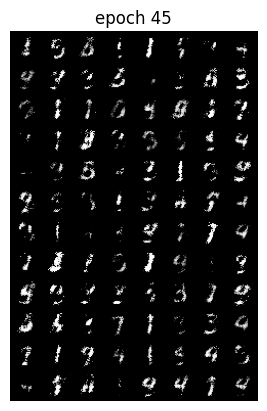

Epoch 45 of 100
Generator loss: 3.11663052, Discriminator loss: 0.53400409


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:07,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  7.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:06,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:06,  7.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:11<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.35it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 46 of 100
Generator loss: 2.94149184, Discriminator loss: 0.47203956


  1%|          | 1/117 [00:00<00:13,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:12,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:12,  7.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:12,  7.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:12,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:07<00:07,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:05,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:03,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:02,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:01,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.40it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 47 of 100
Generator loss: 2.93714216, Discriminator loss: 0.49207277


  1%|          | 1/117 [00:00<00:13,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:08,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:08,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.35it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 48 of 100
Generator loss: 3.00966415, Discriminator loss: 0.47154891


  1%|          | 1/117 [00:00<00:14,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:14,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:01<00:13,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:11,  7.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:11,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:11,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:07<00:07,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:08<00:06,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:09<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:10<00:04,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:11<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:14<00:00,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.27it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 49 of 100
Generator loss: 3.28040239, Discriminator loss: 0.41720033


  1%|          | 1/117 [00:00<00:13,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:09,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:07,  7.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:07,  7.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:06,  7.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:01,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.28it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


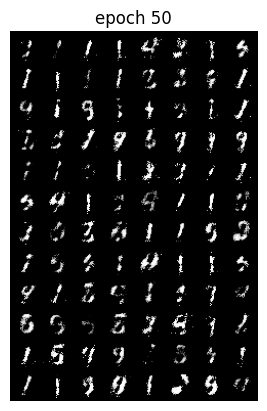

Epoch 50 of 100
Generator loss: 3.12637829, Discriminator loss: 0.52119055


  1%|          | 1/117 [00:00<00:14,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:10,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:10,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:10,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:10,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  7.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:09,  7.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:09,  7.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:09,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:07<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:06,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:01,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.33it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 51 of 100
Generator loss: 2.99229709, Discriminator loss: 0.49565525


  1%|          | 1/117 [00:00<00:14,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.38it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 52 of 100
Generator loss: 2.92085418, Discriminator loss: 0.52486062


  1%|          | 1/117 [00:00<00:14,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:11,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:06<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:03,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.36it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 53 of 100
Generator loss: 3.04101767, Discriminator loss: 0.51784821


  1%|          | 1/117 [00:00<00:13,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:13,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:12,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:12,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:10,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  7.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.36it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 54 of 100
Generator loss: 2.95745109, Discriminator loss: 0.50610630


  1%|          | 1/117 [00:00<00:14,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:11,  7.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:11,  7.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:11,  7.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:10,  7.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:10,  7.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:10,  7.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:10,  7.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:05<00:09,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:04,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.27it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


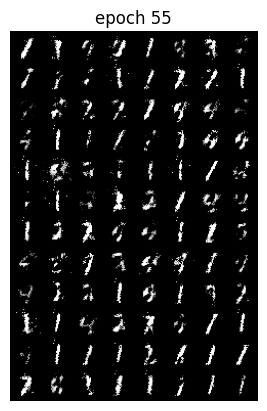

Epoch 55 of 100
Generator loss: 2.90887522, Discriminator loss: 0.48325681


  1%|          | 1/117 [00:00<00:14,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:15,  7.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:12,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:11,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:11,  7.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  7.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:04,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.33it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 56 of 100
Generator loss: 2.95984381, Discriminator loss: 0.46926351


  1%|          | 1/117 [00:00<00:13,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:18,  5.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:15,  6.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:02<00:12,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:10,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  9.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  9.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.59it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 57 of 100
Generator loss: 2.92623316, Discriminator loss: 0.48553495


  2%|▏         | 2/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:08,  9.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  9.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:06,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:06,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:12<00:00,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.68it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 58 of 100
Generator loss: 2.90943881, Discriminator loss: 0.47081991


  1%|          | 1/117 [00:00<00:15,  7.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:15,  7.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:07,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:06,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.46it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 59 of 100
Generator loss: 3.00358162, Discriminator loss: 0.46040689


  1%|          | 1/117 [00:00<00:13,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:14,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:14,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:14,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:08,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:04,  9.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:04,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  9.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:03,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  9.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  9.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  7.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  7.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.60it/s]                         

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


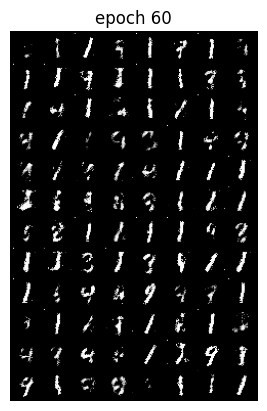

Epoch 60 of 100
Generator loss: 2.97061770, Discriminator loss: 0.47543059


  1%|          | 1/117 [00:00<00:12,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  7.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  9.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  9.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  9.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  9.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:00,  9.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.60it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 61 of 100
Generator loss: 2.77837919, Discriminator loss: 0.48406330


  1%|          | 1/117 [00:00<00:13,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:12,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:12,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:03,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:11<00:01,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:12<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.61it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 62 of 100
Generator loss: 2.90952817, Discriminator loss: 0.50173664


  1%|          | 1/117 [00:00<00:14,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:12,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:05,  7.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:01,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.43it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 63 of 100
Generator loss: 2.82024771, Discriminator loss: 0.54260394


  1%|          | 1/117 [00:00<00:12,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  7.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:10,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:09,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:09,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:09,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:07<00:07,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:07,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:07,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:07,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:08<00:06,  7.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  7.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:09<00:05,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:10<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:11<00:03,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:11<00:03,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:12<00:02,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:13<00:01,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.30it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 64 of 100
Generator loss: 2.76953285, Discriminator loss: 0.54601051


  1%|          | 1/117 [00:00<00:15,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:13,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:13,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:10,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:10,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:08,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:05,  8.04it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:02,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.36it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


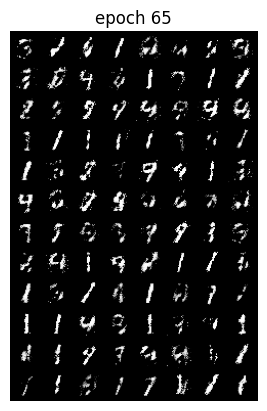

Epoch 65 of 100
Generator loss: 2.66473964, Discriminator loss: 0.54171094


  1%|          | 1/117 [00:00<00:14,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:08,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:08,  7.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:07,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:08<00:06,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:09<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:10<00:04,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:04,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.39it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 66 of 100
Generator loss: 2.67278866, Discriminator loss: 0.55130937


  1%|          | 1/117 [00:00<00:15,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:11,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  9.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  9.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:12,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:12,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:12,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:10,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:07,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:08,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  7.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:04,  7.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.11it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:03,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:03,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  7.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:12<00:02,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.00it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:13<00:00,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.40it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 67 of 100
Generator loss: 2.59780005, Discriminator loss: 0.56978409


  1%|          | 1/117 [00:00<00:14,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:08<00:04,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:09<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:10<00:02,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.03it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:02,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:11<00:01,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:01,  7.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  7.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.51it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 68 of 100
Generator loss: 2.59177384, Discriminator loss: 0.58958846


  1%|          | 1/117 [00:00<00:13,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:12,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:12,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:12,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:12,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.94it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:11,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:11,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.93it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:02<00:10,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.98it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.87it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:03<00:09,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:04<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:08,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:05<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:09,  5.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:07,  6.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  7.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.63it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:10<00:03,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.28it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:11<00:03,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  7.97it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:12<00:02,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:13<00:01,  7.99it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:14<00:00,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:14,  8.28it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 69 of 100
Generator loss: 2.60853987, Discriminator loss: 0.63417599


  1%|          | 1/117 [00:00<00:14,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:13,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:11,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  9.02it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:11,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:10,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:09,  8.82it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:09,  8.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:09,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:03<00:09,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:10,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:09,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:09,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:09,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:09,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:07,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:07,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:07,  8.25it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.46it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.19it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:06,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:06,  7.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:04,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.77it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:04,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  7.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  7.90it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  7.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.45it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])


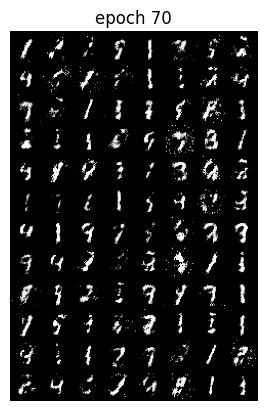

Epoch 70 of 100
Generator loss: 2.58017284, Discriminator loss: 0.61343828


  1%|          | 1/117 [00:00<00:13,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:13,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:13,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:14,  7.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:14,  7.80it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:13,  7.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:13,  7.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:13,  7.76it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:13,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:12,  8.22it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:12,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:02<00:11,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.41it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:12,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.16it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:11,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:11,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:03<00:11,  7.91it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:11,  7.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:11,  7.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:11,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.12it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:10,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:09,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:04<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:09,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:05<00:08,  8.56it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:08,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:06<00:07,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:06<00:07,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:07,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:07<00:06,  8.70it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:07<00:06,  8.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.92it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:05,  9.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:05,  9.13it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:05,  9.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:08<00:05,  8.59it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.95it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:09<00:04,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.08it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.33it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:10<00:03,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:11<00:02,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.17it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.15it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.31it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.37it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.34it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  7.79it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  7.88it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.20it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.35it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:13<00:00,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 96%|█████████▌| 112/117 [00:13<00:00,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 113/117 [00:13<00:00,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 97%|█████████▋| 114/117 [00:13<00:00,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 98%|█████████▊| 115/117 [00:13<00:00,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 99%|█████████▉| 116/117 [00:13<00:00,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


118it [00:13,  8.46it/s]                         


Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])
Discriminator output size (real): torch.Size([96, 1]), Label size (real): torch.Size([96, 1])
Discriminator output size (fake): torch.Size([96, 1]), Label size (fake): torch.Size([96, 1])
Epoch 71 of 100
Generator loss: 2.34971336, Discriminator loss: 0.63687745


  1%|          | 1/117 [00:00<00:13,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  2%|▏         | 2/117 [00:00<00:14,  7.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 3/117 [00:00<00:14,  8.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  3%|▎         | 4/117 [00:00<00:13,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  4%|▍         | 5/117 [00:00<00:13,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  5%|▌         | 6/117 [00:00<00:13,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  6%|▌         | 7/117 [00:00<00:12,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  7%|▋         | 8/117 [00:00<00:12,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  8%|▊         | 9/117 [00:01<00:12,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▊         | 10/117 [00:01<00:12,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


  9%|▉         | 11/117 [00:01<00:12,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 10%|█         | 12/117 [00:01<00:12,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 11%|█         | 13/117 [00:01<00:12,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 12%|█▏        | 14/117 [00:01<00:11,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 13%|█▎        | 15/117 [00:01<00:11,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 14%|█▎        | 16/117 [00:01<00:11,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▍        | 17/117 [00:01<00:11,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 15%|█▌        | 18/117 [00:02<00:11,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 16%|█▌        | 19/117 [00:02<00:12,  8.14it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 17%|█▋        | 20/117 [00:02<00:11,  8.21it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 18%|█▊        | 21/117 [00:02<00:11,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 19%|█▉        | 22/117 [00:02<00:11,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 20%|█▉        | 23/117 [00:02<00:10,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██        | 24/117 [00:02<00:10,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 21%|██▏       | 25/117 [00:02<00:10,  8.67it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 22%|██▏       | 26/117 [00:03<00:10,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 23%|██▎       | 27/117 [00:03<00:10,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 24%|██▍       | 28/117 [00:03<00:10,  8.78it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 25%|██▍       | 29/117 [00:03<00:10,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▌       | 30/117 [00:03<00:11,  7.89it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 26%|██▋       | 31/117 [00:03<00:10,  8.06it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 27%|██▋       | 32/117 [00:03<00:10,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 28%|██▊       | 33/117 [00:03<00:09,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 29%|██▉       | 34/117 [00:04<00:09,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 30%|██▉       | 35/117 [00:04<00:09,  8.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 31%|███       | 36/117 [00:04<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 37/117 [00:04<00:09,  8.75it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 32%|███▏      | 38/117 [00:04<00:09,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 33%|███▎      | 39/117 [00:04<00:08,  8.83it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 34%|███▍      | 40/117 [00:04<00:08,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 35%|███▌      | 41/117 [00:04<00:08,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 36%|███▌      | 42/117 [00:04<00:08,  9.10it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 37%|███▋      | 43/117 [00:05<00:08,  9.01it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 44/117 [00:05<00:08,  8.96it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 38%|███▊      | 45/117 [00:05<00:08,  8.81it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 39%|███▉      | 46/117 [00:05<00:08,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 40%|████      | 47/117 [00:05<00:08,  8.54it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 41%|████      | 48/117 [00:05<00:07,  8.72it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 42%|████▏     | 49/117 [00:05<00:08,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 43%|████▎     | 50/117 [00:05<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▎     | 51/117 [00:05<00:07,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 44%|████▍     | 52/117 [00:06<00:07,  8.84it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 45%|████▌     | 53/117 [00:06<00:07,  8.85it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 46%|████▌     | 54/117 [00:06<00:07,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 47%|████▋     | 55/117 [00:06<00:07,  8.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 48%|████▊     | 56/117 [00:06<00:07,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 49%|████▊     | 57/117 [00:06<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|████▉     | 58/117 [00:06<00:06,  8.60it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 50%|█████     | 59/117 [00:06<00:06,  8.66it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 51%|█████▏    | 60/117 [00:06<00:06,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 52%|█████▏    | 61/117 [00:07<00:06,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 53%|█████▎    | 62/117 [00:07<00:06,  8.52it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 54%|█████▍    | 63/117 [00:07<00:06,  8.07it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 55%|█████▍    | 64/117 [00:07<00:06,  7.71it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▌    | 65/117 [00:07<00:06,  7.57it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 56%|█████▋    | 66/117 [00:07<00:06,  7.86it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 57%|█████▋    | 67/117 [00:07<00:06,  8.09it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 58%|█████▊    | 68/117 [00:07<00:05,  8.26it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 59%|█████▉    | 69/117 [00:08<00:05,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 60%|█████▉    | 70/117 [00:08<00:05,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 61%|██████    | 71/117 [00:08<00:05,  8.64it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 72/117 [00:08<00:05,  8.68it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 62%|██████▏   | 73/117 [00:08<00:05,  8.49it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 63%|██████▎   | 74/117 [00:08<00:05,  8.45it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 64%|██████▍   | 75/117 [00:08<00:04,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 65%|██████▍   | 76/117 [00:08<00:04,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 66%|██████▌   | 77/117 [00:09<00:04,  8.69it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 67%|██████▋   | 78/117 [00:09<00:04,  8.73it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 79/117 [00:09<00:04,  8.29it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 68%|██████▊   | 80/117 [00:09<00:04,  8.39it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 69%|██████▉   | 81/117 [00:09<00:04,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 70%|███████   | 82/117 [00:09<00:04,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 71%|███████   | 83/117 [00:09<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 72%|███████▏  | 84/117 [00:09<00:03,  8.65it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 73%|███████▎  | 85/117 [00:09<00:03,  8.62it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▎  | 86/117 [00:10<00:03,  8.42it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 74%|███████▍  | 87/117 [00:10<00:03,  8.05it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 75%|███████▌  | 88/117 [00:10<00:03,  8.40it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 76%|███████▌  | 89/117 [00:10<00:03,  8.61it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 77%|███████▋  | 90/117 [00:10<00:03,  8.53it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 78%|███████▊  | 91/117 [00:10<00:03,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▊  | 92/117 [00:10<00:02,  8.48it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 79%|███████▉  | 93/117 [00:10<00:02,  8.50it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 80%|████████  | 94/117 [00:11<00:02,  8.51it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 81%|████████  | 95/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 82%|████████▏ | 96/117 [00:11<00:02,  8.55it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 83%|████████▎ | 97/117 [00:11<00:02,  8.36it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 84%|████████▍ | 98/117 [00:11<00:02,  8.44it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▍ | 99/117 [00:11<00:02,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 85%|████████▌ | 100/117 [00:11<00:02,  8.18it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 86%|████████▋ | 101/117 [00:11<00:01,  8.27it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 87%|████████▋ | 102/117 [00:12<00:01,  8.23it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 88%|████████▊ | 103/117 [00:12<00:01,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 89%|████████▉ | 104/117 [00:12<00:01,  8.30it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 90%|████████▉ | 105/117 [00:12<00:01,  8.24it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████ | 106/117 [00:12<00:01,  8.43it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 91%|█████████▏| 107/117 [00:12<00:01,  8.32it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 92%|█████████▏| 108/117 [00:12<00:01,  8.47it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 93%|█████████▎| 109/117 [00:12<00:00,  8.38it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 94%|█████████▍| 110/117 [00:12<00:00,  8.58it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


 95%|█████████▍| 111/117 [00:13<00:00,  8.74it/s]

Discriminator output size (real): torch.Size([512, 1]), Label size (real): torch.Size([512, 1])
Discriminator output size (fake): torch.Size([512, 1]), Label size (fake): torch.Size([512, 1])


In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        real_images, _ = data
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Adjust label size based on current batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # Train Discriminator
        discriminator.zero_grad()

        # Train Discriminator with Real Images
        outputs = discriminator(real_images)
        print(f"Discriminator output size (real): {outputs.size()}, Label size (real): {real_labels.size()}")
        real_loss = discriminator_loss(outputs, real_labels)

        # Generate Fake Images
        noise = create_noise(current_batch_size, nz)  # Adjust noise vector size
        fake_images = generator(noise)

        # Train Discriminator with Fake Images
        outputs = discriminator(fake_images.detach())
        print(f"Discriminator output size (fake): {outputs.size()}, Label size (fake): {fake_labels.size()}")
        fake_loss = discriminator_loss(outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_d.step()

        loss_d += d_loss.item()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = generator_loss(outputs, real_labels)
        g_loss.backward()
        optim_g.step()

        loss_g += g_loss.item()




    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    generated_img = make_grid(generated_img)

    # vis
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the model
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [28]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [29]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

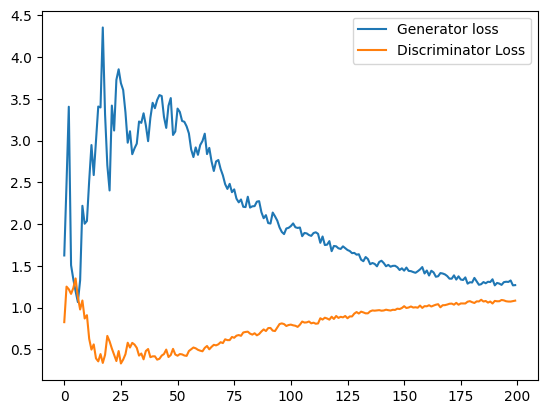

In [30]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')